# **_Stock Market Trend Analysis (2021–2025)_**
### Group Members:
- Farhan Haider
- Imran Khan
- Saad Farooq
****

### **Datasets:** Companies Listing.csv, Pakistan Stock Market Data 2021-2025.csv

In [15]:
import pandas as pd, numpy as np, math, os

In [16]:
import matplotlib.pyplot as plt, seaborn as sns

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (12,5)
sns.set_theme(style="darkgrid")

In [18]:
# Load datasets
PRICES_CSV = "https://raw.githubusercontent.com/farhanhaider95/StockMarketTrendSystem/refs/heads/main/Pakistan%20Stock%20Market%20Data%202021-2025.csv"
COMPANIES_CSV = "https://raw.githubusercontent.com/farhanhaider95/StockMarketTrendSystem/refs/heads/main/Companies%20Listing.csv"

# read as strings to guard parsing issues
df = pd.read_csv(PRICES_CSV, dtype=str)
symbol_info = pd.read_csv(COMPANIES_CSV, dtype=str)

print("Raw rows:", len(df), "Company rows:", len(symbol_info))
df.head()


Raw rows: 476696 Company rows: 553


,DATE,SYMBOL,LDCP,OPEN,HIGH,LOW,CLOSE,CHANGE,CHANGE (%),VOLUME
0,1/1/2021,786,11.81,11.94,12.79,11.81,12.07,0.26,2.201524132,121000
1,1/1/2021,AABS,335.97,349,349,336.01,341.73,5.76,1.714438789,1400
2,1/1/2021,ABL,85.37,84.66,85.9,83.85,83.99,-1.38,-1.616492913,125500
3,1/1/2021,ABOT,755.37,756,756,745.01,750.95,-4.42,-0.585143704,2550
4,1/1/2021,ACPL,150.05,153,153.9,148.5,149.48,-0.57,-0.379873376,167100


### 2. Clean column names, parse dates, numeric conversions
- Normalize column names
- Parse date with `dayfirst=True` to handle `DD-MM-YY` and `MM/DD/YYYY`
- Convert numeric columns (remove commas/percent signs)
- Drop rows lacking essential values


In [19]:
# Normalize columns & parse date ---
# Normalize column names (strip & upper)
df.columns = df.columns.str.strip().str.upper()
symbol_info.columns = symbol_info.columns.str.strip().str.upper()

# Show columns
print("Price columns:", df.columns.tolist())
print("Symbol columns:", symbol_info.columns.tolist())

# Parse DATE robustly
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['DATE']).copy()

# Normalize SYMBOL
df['SYMBOL'] = df['SYMBOL'].str.strip().str.upper()
symbol_info['SYMBOL'] = symbol_info['SYMBOL'].str.strip().str.upper()

# Clean numeric columns and convert
numeric_cols = ['LDCP','OPEN','HIGH','LOW','CLOSE','CHANGE','CHANGE (%)','VOLUME']
# If 'CHANGE (%)' has percent sign, remove
if 'CHANGE (%)' in df.columns:
    df['CHANGE (%)'] = df['CHANGE (%)'].str.replace('%','', regex=False)
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].str.replace(',','', regex=False), errors='coerce')

# Drop rows without CLOSE (essential)
df = df.dropna(subset=['CLOSE']).copy()

# Sort for group operations
df = df.sort_values(['SYMBOL','DATE']).reset_index(drop=True)
df.info()


Price columns: ['DATE', 'SYMBOL', 'LDCP', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'CHANGE', 'CHANGE (%)', 'VOLUME']
Symbol columns: ['SYMBOL', 'NAME', 'SECTOR', 'STATUS']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188123 entries, 0 to 188122
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   DATE        188123 non-null  datetime64[ns]
 1   SYMBOL      188123 non-null  object        
 2   LDCP        188123 non-null  float64       
 3   OPEN        188123 non-null  float64       
 4   HIGH        188123 non-null  float64       
 5   LOW         188123 non-null  float64       
 6   CLOSE       188123 non-null  float64       
 7   CHANGE      188123 non-null  float64       
 8   CHANGE (%)  188120 non-null  float64       
 9   VOLUME      188123 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 14.4+ MB


### 3. Merge company listing (sector & status)

In [20]:
# Prepare symbol_info & merge
# Keep required columns if present
keep_cols = ['SYMBOL','NAME','SECTOR','STATUS']
keep_cols = [c for c in keep_cols if c in symbol_info.columns]
symbol_info = symbol_info[keep_cols].drop_duplicates(subset=['SYMBOL'])

# Drop any pre-existing NAME/SECTOR/STATUS from df to avoid duplicates
for c in ['NAME','SECTOR','STATUS']:
    if c in df.columns:
        df = df.drop(columns=[c])

# Merge
df = df.merge(symbol_info, on='SYMBOL', how='left')

# Quick check
print("Merged; missing sector count:", df['SECTOR'].isna().sum())
df[['SYMBOL','NAME','SECTOR','STATUS']].drop_duplicates().head()


Merged; missing sector count: 15562


,SYMBOL,NAME,SECTOR,STATUS
0,786,786 Investments Limited,INV. BANKS / INV. COS. / SECURITIES COS.,Compliant
398,AABS,Al-Abbas Sugar Mills Limited,SUGAR & ALLIED INDUSTRIES,Compliant
776,AAL,Agro Allianz Limited,TEXTILE SPINNING,Non Compliant
785,AASM,Al-Abid Silk Mills Limited,SYNTHETIC & RAYON,Non Compliant
794,AATM,Ali Asghar Textile Mills Limited,TEXTILE SPINNING,Compliant


### 4. Derived fields: returns, log returns, YEAR/MONTH

In [21]:
# Derived columns ---
df['RET'] = df.groupby('SYMBOL')['CLOSE'].pct_change()
df['LOG_RET'] = np.log(df['CLOSE']) - np.log(df['CLOSE'].shift(1))
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month
df['DAY'] = df['DATE'].dt.day
df.head()

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,DATE,SYMBOL,LDCP,OPEN,HIGH,LOW,CLOSE,CHANGE,CHANGE (%),VOLUME,NAME,SECTOR,STATUS,RET,LOG_RET,YEAR,MONTH,DAY
0,2021-01-01,786,11.81,11.94,12.79,11.81,12.07,0.26,2.201524,121000,786 Investments Limited,INV. BANKS / INV. COS. / SECURITIES COS.,Compliant,NaN,NaN,2021,1,1
1,2021-01-04,786,12.07,12.60,12.60,12.00,12.06,-0.01,-0.082850,70000,786 Investments Limited,INV. BANKS / INV. COS. / SECURITIES COS.,Compliant,-0.000829,-0.000829,2021,1,4
2,2021-01-05,786,12.06,12.10,12.65,12.09,12.38,0.32,2.653400,112500,786 Investments Limited,INV. BANKS / INV. COS. / SECURITIES COS.,Compliant,0.026534,0.026188,2021,1,5
3,2021-01-06,786,12.38,12.50,12.69,12.15,12.19,-0.19,-1.534733,39000,786 Investments Limited,INV. BANKS / INV. COS. / SECURITIES COS.,Compliant,-0.015347,-0.015466,2021,1,6
4,2021-01-07,786,12.19,12.11,12.40,12.05,12.16,-0.03,-0.246103,66500,786 Investments Limited,INV. BANKS / INV. COS. / SECURITIES COS.,Compliant,-0.002461,-0.002464,2021,1,7


### 5. Data quality & EDA: summary statistics, top symbols, missingness

In [22]:
# Basic EDA ---
display(df[['OPEN','HIGH','LOW','CLOSE','VOLUME']].describe())
top_symbols = df['SYMBOL'].value_counts().head(20)
print("Top symbols by record counts:\n", top_symbols)

,OPEN,HIGH,LOW,CLOSE,VOLUME
count,188123.000000,188123.000000,188123.000000,188123.000000,1.881230e+05
mean,183.046880,187.098206,181.251999,187.660831,2.827169e+06
std,1067.710552,1086.257858,1056.069151,1077.333877,1.121536e+08
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,9.300000,9.700000,9.210000,10.270000,3.000000e+03
50%,28.000000,28.910000,27.850000,30.600000,3.300000e+04
75%,104.500000,106.950000,103.100000,106.900000,4.180000e+05
max,39097.510000,39097.510000,35543.190000,35543.190000,3.310840e+10


Top symbols by record counts:
 SYMBOL
UNITY    467
UBL      467
AKBL     467
AGP      467
AGL      467
TRG      467
TREET    467
TOMCL    467
TPL      467
TELE     467
TGL      467
ANL      467
STCL     467
SYS      467
STPL     467
SSGC     467
SAZEW    467
SNGP     467
SPWL     467
AGHA     467
Name: count, dtype: int64


### 6. Yearly returns per symbol & sector aggregation
We compute annual returns per symbol and aggregate by sector for year×sector analysis.

In [33]:
# Yearly returns & sector aggregation ---
def compute_yearly_returns(df):
    out = df.sort_values('DATE').groupby(['SYMBOL','YEAR'])['CLOSE'].agg(first='first', last='last').reset_index()
    out['ANNUAL_RETURN'] = out['last'] / out['first'] - 1
    return out

yearly = compute_yearly_returns(df)
sym_sector = df[['SYMBOL','SECTOR']].drop_duplicates(subset=['SYMBOL'])
yearly = yearly.merge(sym_sector, on='SYMBOL', how='left')
sector_year = yearly.groupby(['SECTOR','YEAR'])['ANNUAL_RETURN'].mean().reset_index()
pivot_sector_year = sector_year.pivot(index='SECTOR', columns='YEAR', values='ANNUAL_RETURN').fillna(0)

# Show table
pivot_sector_year.head(20)

YEAR,2021,2022,2023,2024,2025
SECTOR,,,,,
AUTOMOBILE ASSEMBLER,-0.261974,-0.098397,0.715031,1.429794,0.173364
AUTOMOBILE PARTS & ACCESSORIES,-0.290840,-0.353403,0.775230,1.685458,-0.038431
CABLE & ELECTRICAL GOODS,0.151334,-0.202406,0.366372,0.350070,0.187072
CEMENT,-0.198127,-0.302933,0.661804,1.180437,0.341752
CHEMICAL,0.049166,-0.106253,0.339652,0.962487,0.335092
CLOSE - END MUTUAL FUND,-0.238403,-0.297509,0.850735,0.096830,0.672082
COMMERCIAL BANKS,0.033290,-0.185610,0.523579,0.476138,0.809324
ENGINEERING,-0.071504,-0.326852,0.309648,0.233013,0.759897
EXCHANGE TRADED FUNDS,-0.136590,-0.115995,0.508400,0.427762,0.224985


### 7. Bar charts for sector volume analysis

C:\Users\Farhan Haidar\AppData\Local\Temp\ipykernel_13124\3819503734.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sector_volume.index, y=sector_volume.values, palette='viridis')


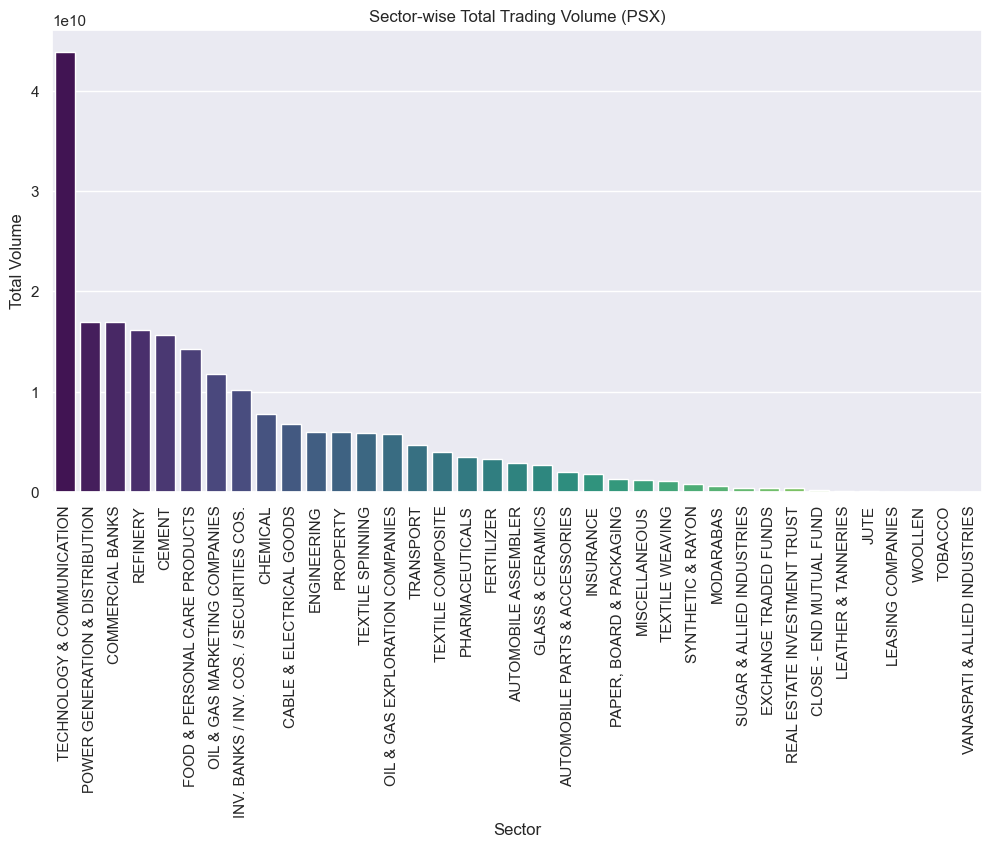

In [30]:
# Sector-wise Volume Analysis ---
sector_volume = df.groupby('SECTOR')['VOLUME'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=sector_volume.index, y=sector_volume.values, palette='viridis')
plt.xticks(rotation=90)
plt.title("Sector-wise Total Trading Volume (PSX)")
plt.ylabel("Total Volume")
plt.xlabel("Sector")
plt.show()

### 8. Sector heatmap (visual)

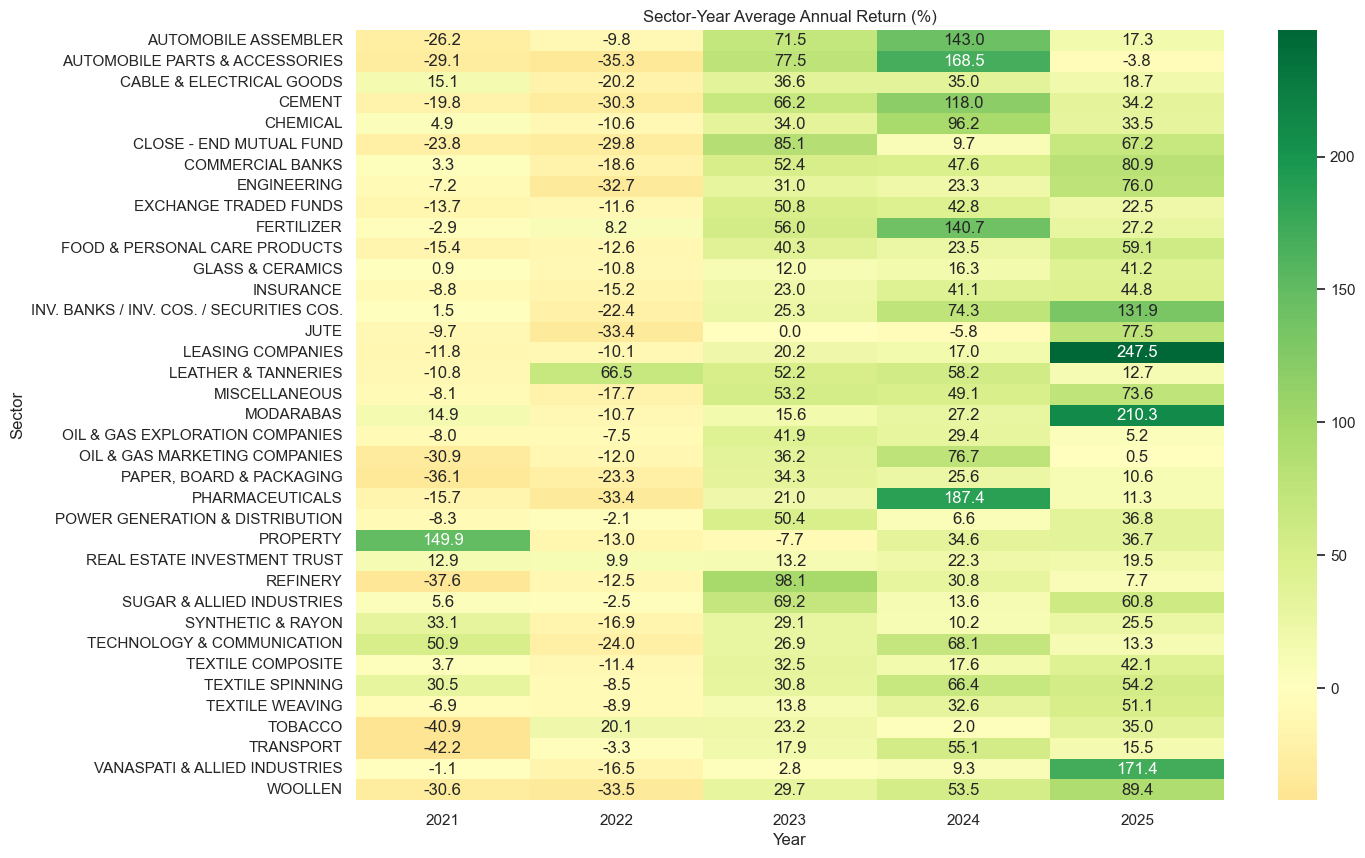

In [24]:
# Sector × Year heatmap ---
plt.figure(figsize=(14,10))
sns.heatmap(pivot_sector_year*100, annot=True, fmt=".1f", cmap='RdYlGn', center=0)
plt.title('Sector-Year Average Annual Return (%)')
plt.xlabel('Year'); plt.ylabel('Sector')
plt.show()

### 9. Line Graphs for top 5 performing sectors in 5 years

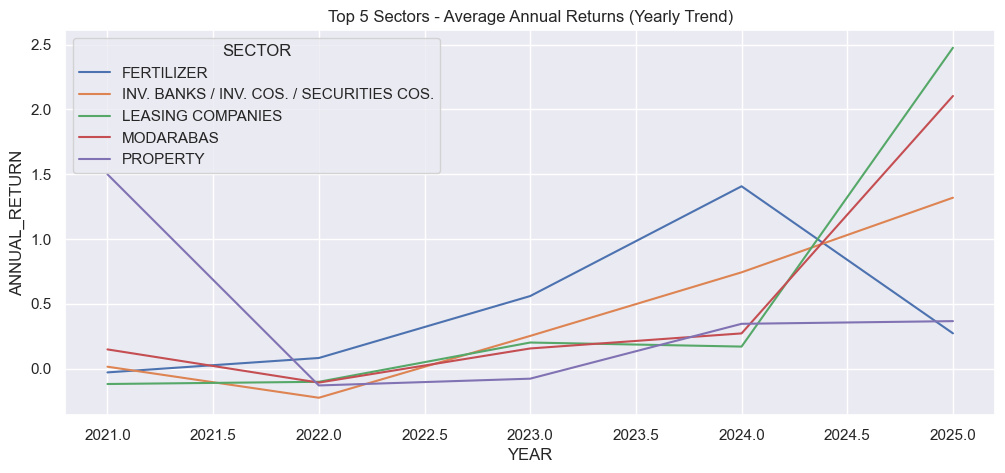

In [39]:
# Compute mean return per sector
sector_mean = sector_year.groupby('SECTOR')['ANNUAL_RETURN'].mean()

# Get top 5 sectors
top5_sectors = sector_mean.sort_values(ascending=False).head(5).index

sector_top5 = sector_year[sector_year['SECTOR'].isin(top5_sectors)]

sns.lineplot(data=sector_top5, x='YEAR', y='ANNUAL_RETURN', hue='SECTOR')
plt.title("Top 5 Sectors - Average Annual Returns (Yearly Trend)")
plt.show()

### 10. Technical indicators (SMA, EMA, RSI, MACD) and plotting
We'll create functions and apply to a single symbol for plotting.

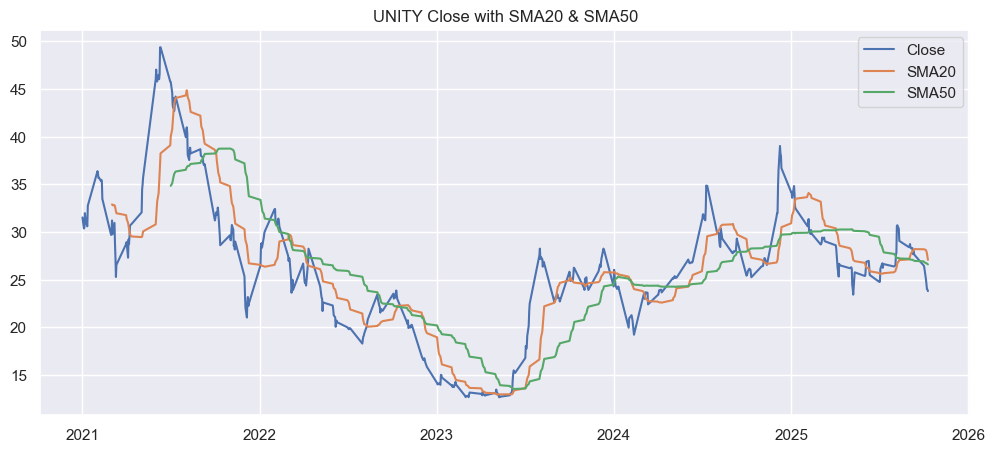

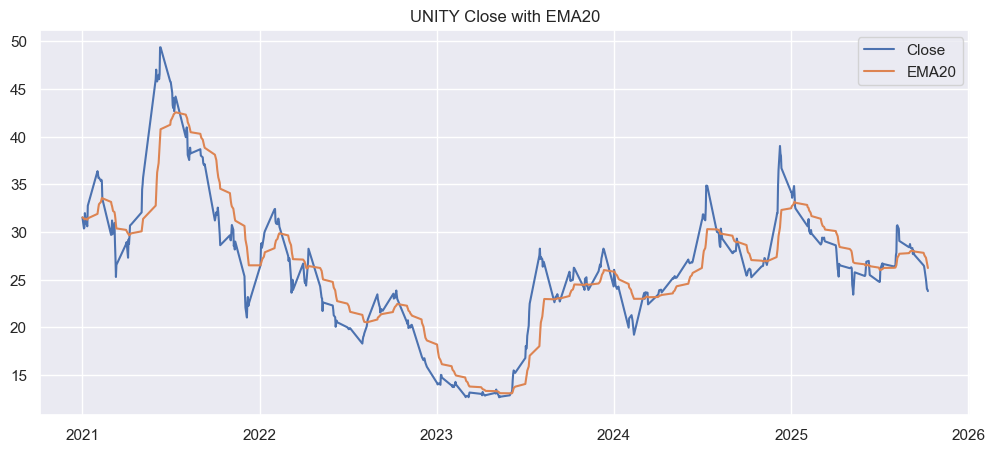

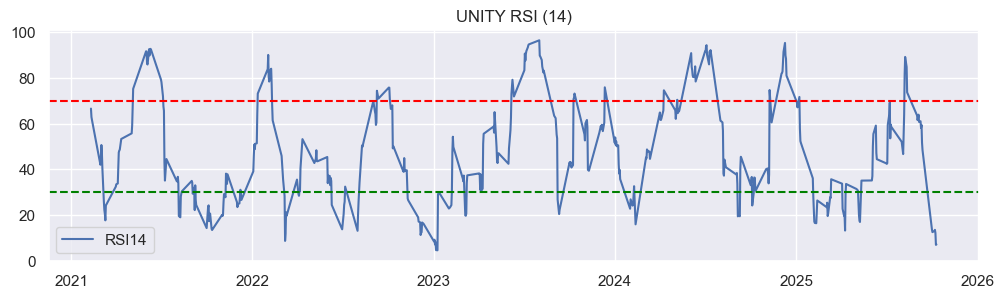

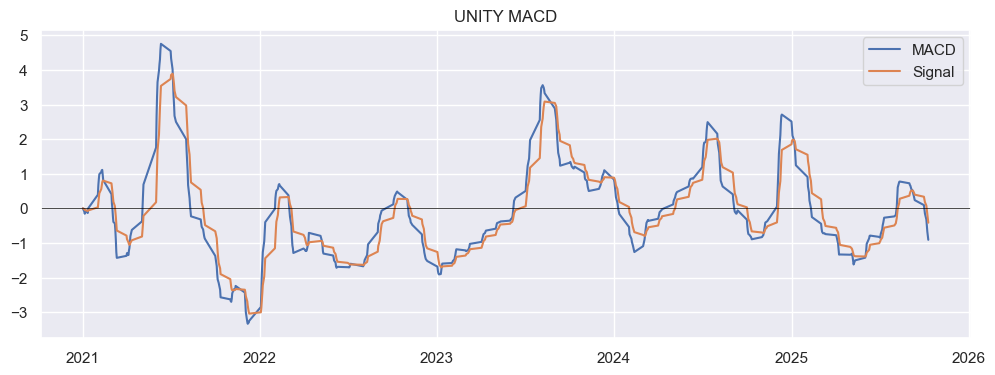

In [41]:
# Indicators functions ---
def SMA(series, window): return series.rolling(window).mean()
def EMA(series, window): return series.ewm(span=window, adjust=False).mean()

def RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def MACD(series):
    ema12 = EMA(series, 12)
    ema26 = EMA(series, 26)
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

# Apply and plot for chosen symbol
sym = top_symbols.index[0]  # picking the first (most traded) symbol
sdf = df[df['SYMBOL']==sym].sort_values('DATE').copy()
sdf['SMA20'] = SMA(sdf['CLOSE'], 20)
sdf['SMA50'] = SMA(sdf['CLOSE'], 50)
sdf['EMA20'] = EMA(sdf['CLOSE'], 20)
sdf['RSI14'] = RSI(sdf['CLOSE'], 14)
sdf['MACD'], sdf['MACD_SIGNAL'] = MACD(sdf['CLOSE'])

# Plot Close + SMAs
plt.figure(figsize=(12,5))
plt.plot(sdf['DATE'], sdf['CLOSE'], label='Close')
plt.plot(sdf['DATE'], sdf['SMA20'], label='SMA20')
plt.plot(sdf['DATE'], sdf['SMA50'], label='SMA50')
plt.legend()
plt.title(f"{sym} Close with SMA20 & SMA50")
plt.show()

# Plot EMA
plt.figure(figsize=(12,5))
plt.plot(sdf['DATE'], sdf['CLOSE'], label='Close')
plt.plot(sdf['DATE'], sdf['EMA20'], label='EMA20')
plt.legend()
plt.title(f"{sym} Close with EMA20")
plt.show()

# RSI
plt.figure(figsize=(12,3))
plt.plot(sdf['DATE'], sdf['RSI14'], label='RSI14')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend()
plt.title(f"{sym} RSI (14)")
plt.show()

# MACD
plt.figure(figsize=(12,4))
plt.plot(sdf['DATE'], sdf['MACD'], label='MACD')
plt.plot(sdf['DATE'], sdf['MACD_SIGNAL'], label='Signal')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.title(f"{sym} MACD")
plt.show()

### 11. Save processed outputs
Save processed CSVs and ML results to `outputs/` for submission.

In [ ]:
# Save outputs 
os.makedirs('outputs', exist_ok=True)
df.to_csv('outputs/processed_psx_2021_2025.csv', index=False)
yearly.to_csv('outputs/yearly_returns_by_symbol.csv', index=False)
pivot_sector_year.to_csv('outputs/sector_year_avg_returns.csv')
if 'results_df' in globals():
    results_df.to_csv('outputs/ml_results_topN.csv', index=False)
print("Saved outputs to /outputs")

Saved outputs to /outputs
